# Alignment Error

In [1]:
import os
import sys
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import func

sns.set_style("whitegrid")

In [3]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.model.center_of_mass import CenterOfMass
from utilities.model.structure import Structure
from sql_setup import session

## Data Collection

In [4]:
def query_brain_coms(brain, person_id=1):
    # person_id = 1 is Ed
    # person_id = 28 is Bili
    prep_id = brain
    input_type = 'aligned'

    rows = session.query(CenterOfMass)\
        .filter(CenterOfMass.active.is_(True))\
        .filter(CenterOfMass.prep_id == prep_id)\
        .filter(CenterOfMass.person_id == person_id)\
        .filter(CenterOfMass.input_type == input_type)\
        .all()

    row_dict = {}
    for row in rows:
        structure = row.structure.abbreviation
        row_dict[structure] = np.array([row.x, row.y, row.section])
    return row_dict

In [5]:
from utilities.sqlcontroller import SqlController

def get_atlas_centers(
        atlas_box_size=(1000, 1000, 300),
        atlas_box_scales=(10, 10, 20),
        atlas_raw_scale=10
):
    atlas_box_scales = np.array(atlas_box_scales)
    atlas_box_size = np.array(atlas_box_size)
    atlas_box_center = atlas_box_size / 2
    sqlController = SqlController('Atlas')
    atlas_centers = sqlController.get_centers_dict('Atlas')

    for structure, center in atlas_centers.items():
        # transform into the atlas box coordinates that neuroglancer assumes
        center = atlas_box_center + np.array(center) * atlas_raw_scale / atlas_box_scales
        atlas_centers[structure] = center

    return atlas_centers

atlas_coms = get_atlas_centers()

No histology for Atlas
No scan run for Atlas


In [6]:
def prepare_table(brains, person_id):
    structures = set()
    for brain in ['DK39', 'DK41', 'DK43', 'DK54', 'DK55']:
        structures = structures | set(query_brain_coms(brain).keys())
    structures = list(sorted(structures))

    brain_coms = {}
    for brain in brains:
        brain_coms[brain] = query_brain_coms(brain, person_id=person_id)
    
    df = pd.DataFrame()
    for brain in brain_coms.keys():
        offset = [brain_coms[brain][s] - atlas_coms[s]
                  if s in brain_coms[brain] else [np.nan, np.nan, np.nan]
                  for s in structures]
        offset = np.array(offset)
        scale = np.array([10, 10, 20])
        dx, dy, dz = (offset * scale).T
        dist = np.sqrt(dx * dx + dy * dy + dz * dz)

        df_brain = pd.DataFrame()

        data = {}
        data['structure'] = structures
        data['value'] = dx
        data['type'] = 'dx'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = structures
        data['value'] = dy
        data['type'] = 'dy'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = structures
        data['value'] = dz
        data['type'] = 'dz'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = structures
        data['value'] = dist
        data['type'] = 'dist'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        df_brain['brain'] = brain
        df = df.append(df_brain, ignore_index=True)
    return df

## Rigid Alignment Error

In [7]:
df_rigid = prepare_table(['DK39', 'DK41', 'DK43', 'DK52', 'DK54', 'DK55'], person_id=1)
df_rigid

,structure,value,type,brain
0,10N_L,-866.730000,dx,DK39
1,10N_R,-338.210000,dx,DK39
2,3N_L,-79.980000,dx,DK39
3,3N_R,-15.560000,dx,DK39
4,4N_L,NaN,dx,DK39
...,...,...,...,...
547,Pn_L,186.834351,dist,DK55
548,Pn_R,284.635250,dist,DK55
549,SC,NaN,dist,DK55
550,Tz_L,216.742819,dist,DK55


### Full Dynamic Range

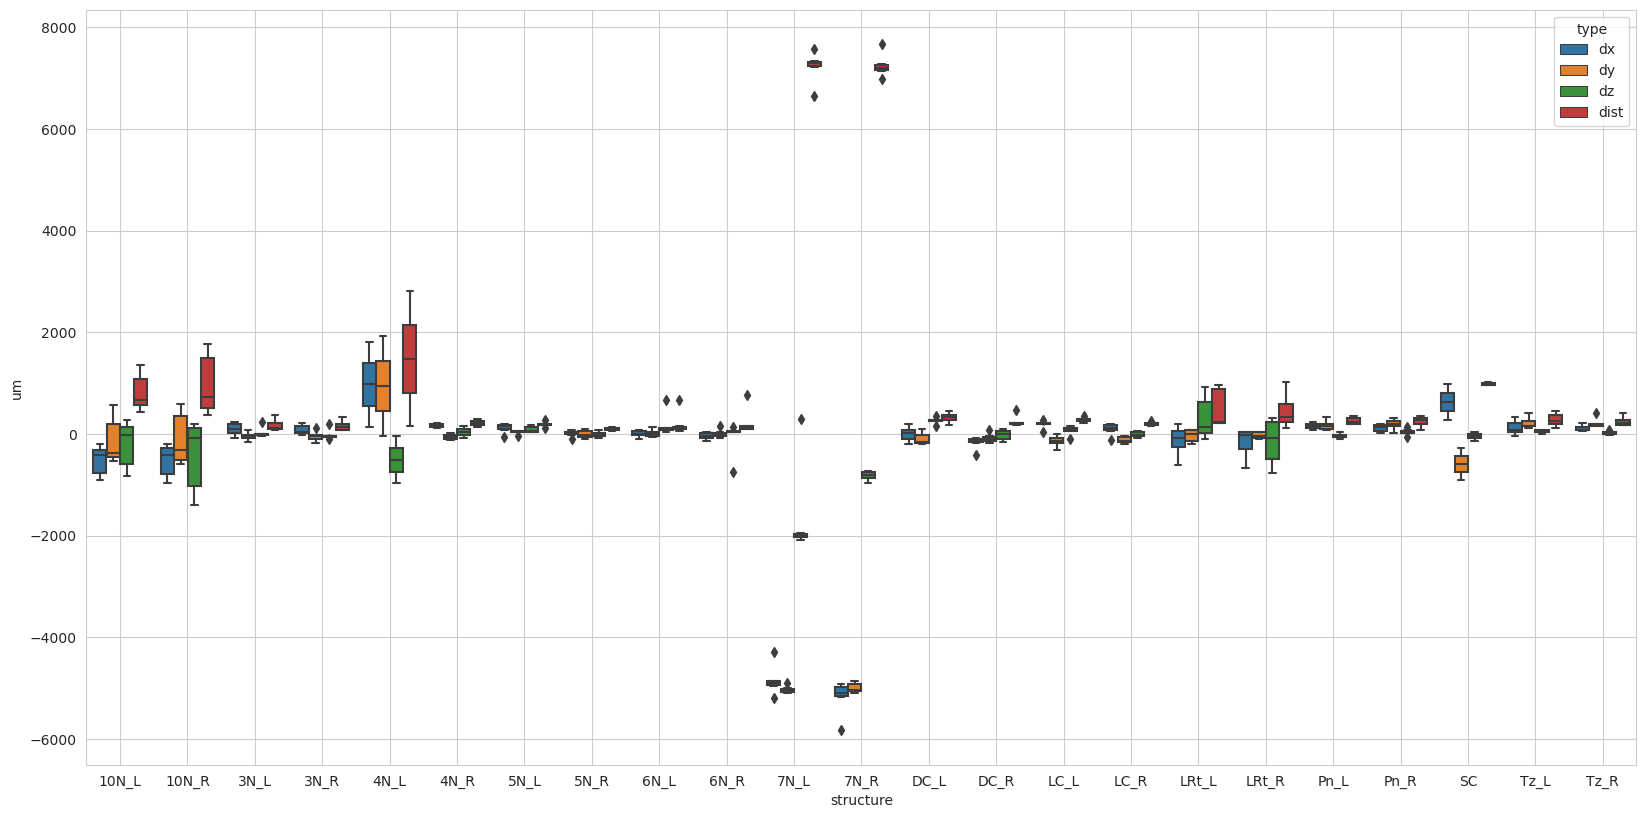

In [8]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rigid)
ax.xaxis.grid(True)
plt.ylabel('um')
plt.show()

### Zoom In

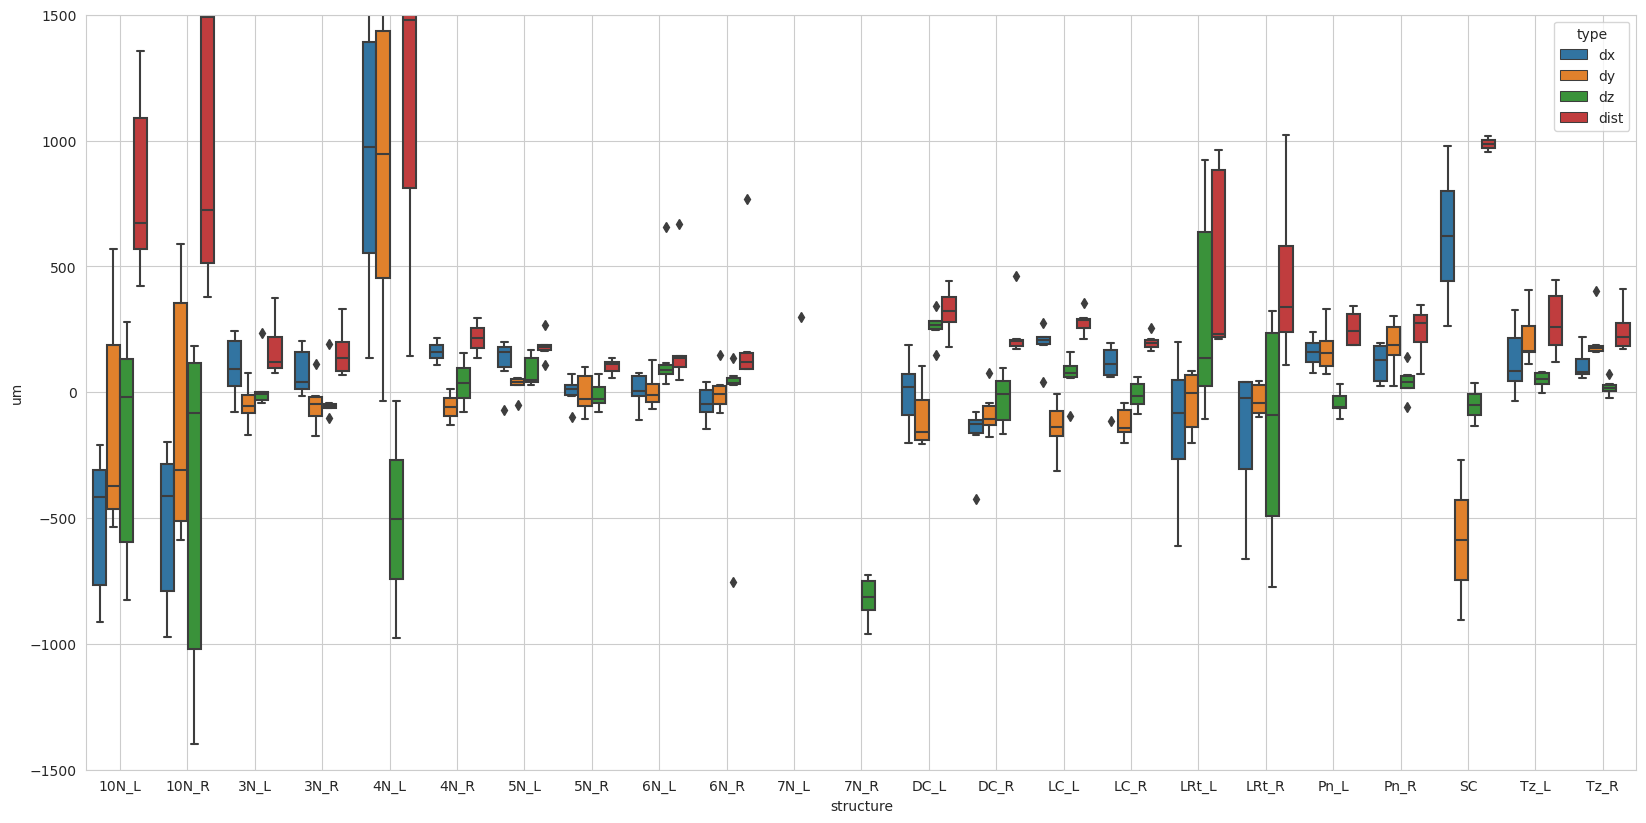

In [9]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rigid)
ax.xaxis.grid(True)
plt.ylabel('um')
plt.ylim(-1500, 1500)
plt.show()

## Rough Alignment Error

In [10]:
df_rough = prepare_table(['DK39', 'DK43', 'DK54'], person_id=28)
df_rough

,structure,value,type,brain
0,10N_L,-337.750000,dx,DK39
1,10N_R,716.170000,dx,DK39
2,3N_L,421.060000,dx,DK39
3,3N_R,448.300000,dx,DK39
4,4N_L,501.990000,dx,DK39
...,...,...,...,...
271,Pn_L,367.912352,dist,DK54
272,Pn_R,1192.125296,dist,DK54
273,SC,NaN,dist,DK54
274,Tz_L,1033.939129,dist,DK54


### Full Dynamic Range

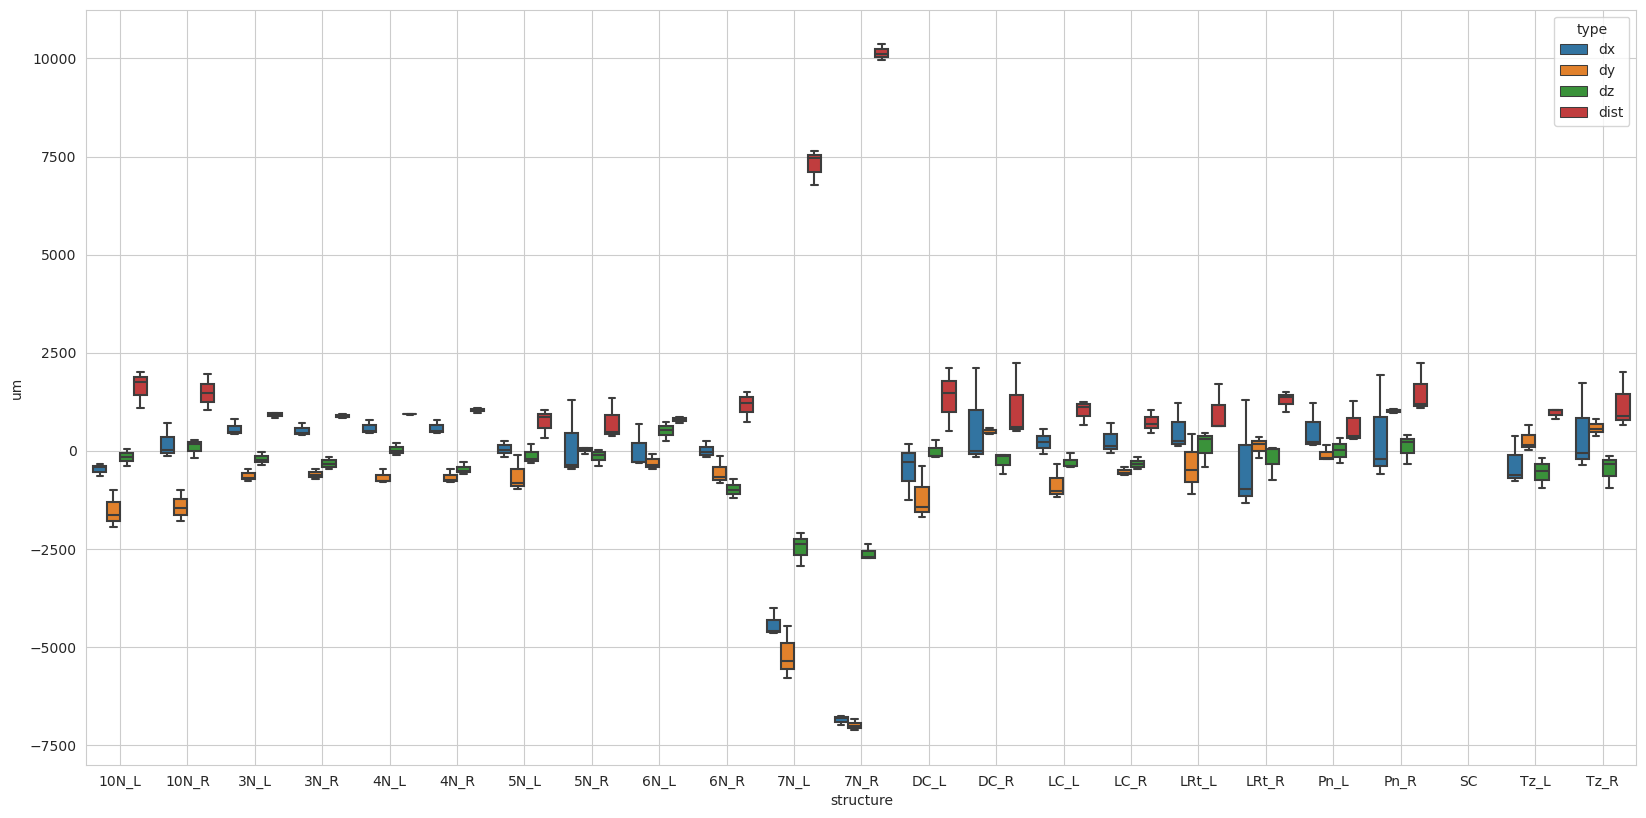

In [11]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rough)
ax.xaxis.grid(True)
plt.ylabel('um')
plt.show()

### Zoom In

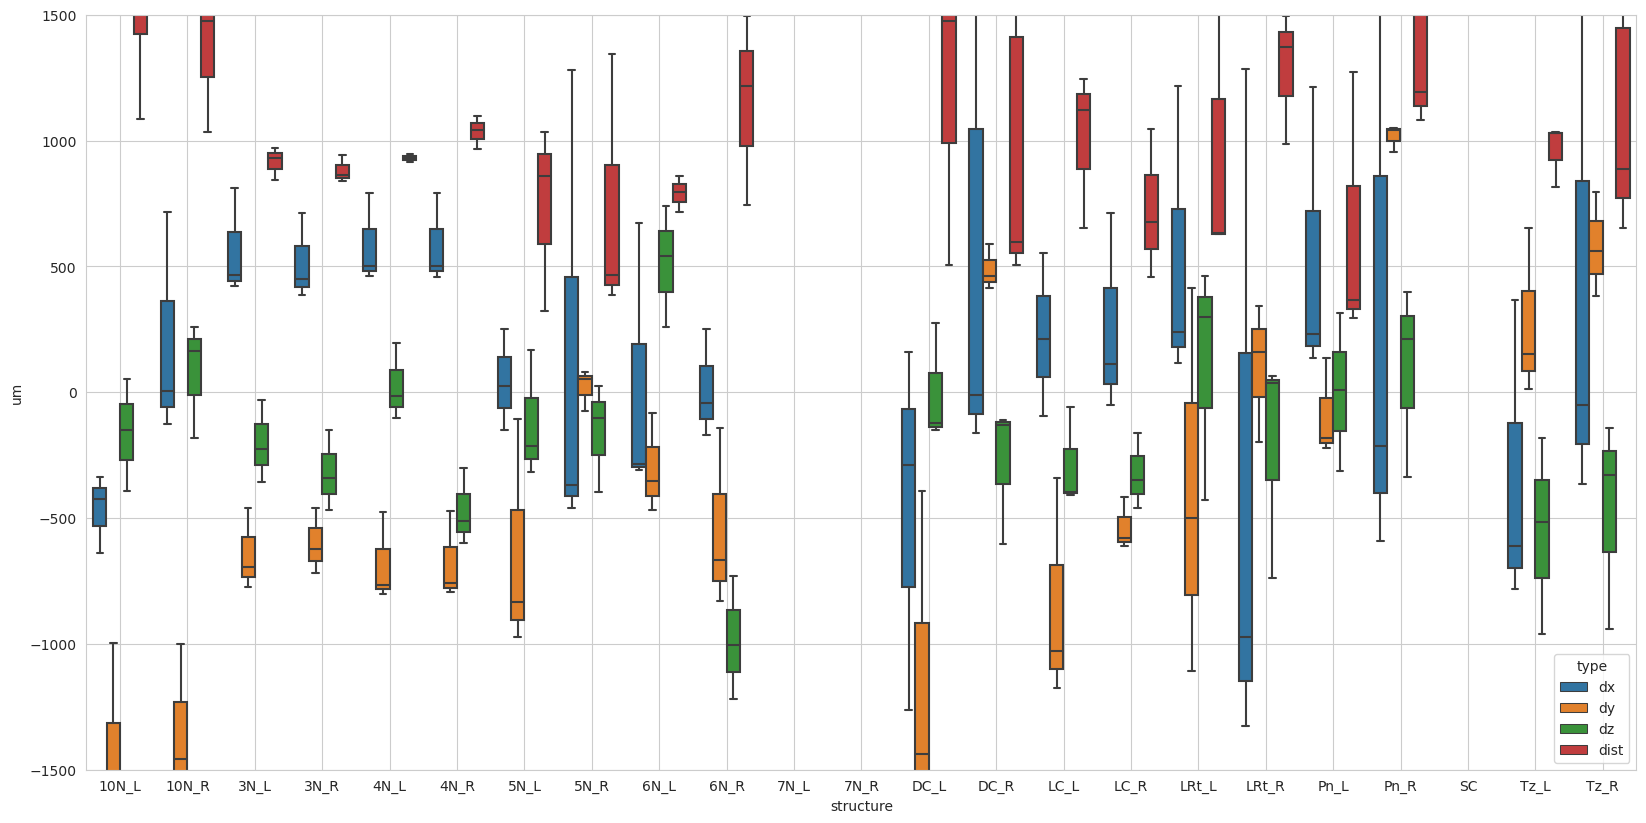

In [12]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rough)
ax.xaxis.grid(True)
plt.ylabel('um')
plt.ylim(-1500, 1500)
plt.show()